In [2]:
import scPhyloX as spx
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.lines as mlines
from scipy.stats import poisson

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
plt.rcParams['font.size'] = 12
plt.rcParams['pdf.fonttype'] = 42

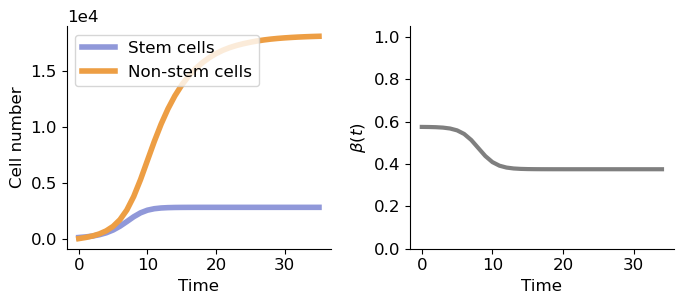

In [4]:
d, p, r, a, b, k, t0 = (0.2, 0.6, 1.3, 0.2, 0.375, 0.8, 8)
K = 35
t = range(K)
x0 = [100, 0]

sol = solve_ivp(spx.sim_tissue.cellnumber, t_span=(0, K), y0=x0, t_eval=range(K+1),
                method='RK45', args=(a, b, k, t0, p, r, d))
fig, ax = plt.subplots(1, 2, figsize=(7,3.2))
ax[0].plot(sol.t, sol.y[0], label='Stem cells', c='#9098d9', lw=4)
ax[0].plot(sol.t, sol.y[1], label='Non-stem cells', c='#ed9e44', lw=4)
ax[0].legend(loc=2)
ax[1].plot(spx.sim_tissue.bt(np.array(t), a, b, k, t0), lw=3, c='tab:gray')
ax[0].set_xlabel('Time')
ax[1].set_xlabel('Time')
ax[0].set_ylabel('Cell number')
ax[1].set_ylabel(r'$\beta(t)$')
ax[1].set_ylim([0,1.05])

ax[0].ticklabel_format (style='sci', scilimits= (-1,2), axis='y')
plt.tight_layout()
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)

In [7]:
mu = 2
system = spx.sim_tissue.simulation(x0, K, mu, a, b, p, r, k, d, t0)

cell_num:19347, time:35.000018494891914

Text(0, 0.5, 'Cell number')

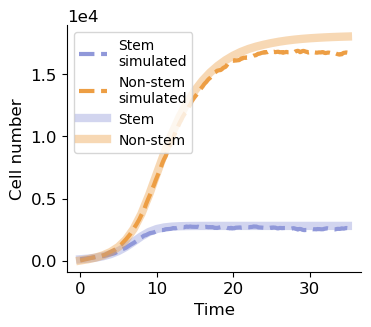

In [8]:
cell_number = np.array(system.n)
fig, ax = plt.subplots(figsize=(3.8, 3.2))
show_tp = np.arange(0, len(system.t),1000)
ax.plot(np.array(system.t)[np.arange(0, len(system.t),1000)], cell_number[np.arange(0, len(system.t),1000), 0], '--', lw=3, label='Stem\nsimulated', c='#9098d9')
ax.plot(np.array(system.t)[np.arange(0, len(system.t),1000)], cell_number[np.arange(0, len(system.t),1000), 1], '--', lw=3, label='Non-stem\nsimulated', c='#ed9e44')
ax.plot(sol.t, sol.y[0], label='Stem', c='#9098d9', lw=6, alpha=0.4)
ax.plot(sol.t, sol.y[1], label='Non-stem', c='#ed9e44', lw=6, alpha=0.4)
ax.legend(loc=2,fontsize=10)
ax.ticklabel_format (style='sci', scilimits= (-1,2), axis='y')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('Time')
ax.set_ylabel('Cell number')

In [8]:
seqtab = np.array([i.seq for i in system.Stemcells] + [i.seq for i in system.Diffcells])
seqtab = seqtab[np.random.choice(range(seqtab.shape[0]), 500, replace=False)]

In [9]:
branch_len = spx.data_factory.get_branchlen(seqtab)
mutnum = spx.data_factory.get_mutnum(seqtab)
ge = spx.est_mr.GenerationEst(mutnum, 2)
gen_num = ge.estimate(cell_number[-1].sum())

100%|██████████| 125250/125250 [00:03<00:00, 41411.28it/s]


In [10]:
n_cyclingcells = np.array([[spx.est_tissue.ncyc(i, j, 100, *[0.32, 1, 1.3, 0.2, 0.8, 8]) for j in range(35)] for i in range(100)])
n_noncyclingcells = np.array([[spx.est_tissue.nnc(i, j, 100, *[0.32, 1, 1.3, 0.2, 0.8, 8]) for j in range(35)] for i in range(100)])

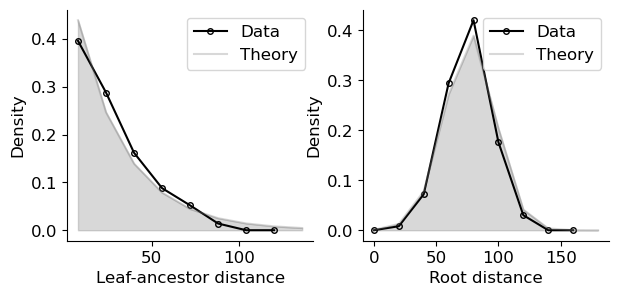

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3))
max_val = 130
n_hist = 8
xrange = np.arange(0, max_val, int(max_val/n_hist))+int(max_val/n_hist)/2
dist = np.histogram(branch_len+1, xrange-int(max_val/n_hist)/2)
th_dist = [spx.est_mr.BranchLength(2, 0.07).prob(i) for i in xrange]
ax[0].plot(xrange[:-1], dist[0]/sum(dist[0]), 'o-', mfc='none', c='black', ms=4, label='Data')
ax[0].plot(xrange, th_dist/sum(th_dist), c='tab:grey',alpha=0.3, label='Theory')
ax[0].fill_between(xrange, th_dist/sum(th_dist), color='tab:grey', alpha=0.3)
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].set_xlabel('Leaf-ancestor distance')
ax[0].set_ylabel('Density')
ax[0].legend()


alpha = n_cyclingcells[:,-1]+n_noncyclingcells[:,-1]
alpha = alpha / sum(alpha)
max_val = 200
n_hist = 10
mutdist = np.histogram(mutnum, np.arange(0, max_val, int(max_val/n_hist)))
th_dist = np.zeros(max_val)
for i, a in enumerate(alpha):
    th_dist = th_dist + a*poisson((i+1)*2).pmf(range(max_val))
th_dist_x = []
th_dist_y = []
for i in range(n_hist):
    th_dist_x.append(i*int(max_val/n_hist))
    th_dist_y.append(np.sum(th_dist[i*int(max_val/n_hist):(i+1)*int(max_val/n_hist)]))
ax[1].plot(mutdist[1][:-1], mutdist[0]/sum(mutdist[0]), 'o-', mfc='none', c='black', ms=4, label='Data')
ax[1].plot(th_dist_x, th_dist_y, c='tab:grey',alpha=0.3, label='Theory')
ax[1].fill_between(th_dist_x, th_dist_y, color='tab:grey', alpha=0.3)
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].set_xlabel('Root distance')
ax[1].set_ylabel('Density')
ax[1].legend()